<a id='top'></a>
# Imaging Mode Data Calibration: Part 1 - Ramps to Slopes
---
**Author**: Bryan Hilbert (hilbert@stsci.edu)| **Latest Update**: 9 April 2021

## Table of Contents
* [Introduction](#intro)
* [Pipeline Resources and Documentation](#resources)
   * [Installation](#installation)
   * [Reference Files](#reference_files)
* [Imports](#imports)
* [Convenience Functions](#convenience_functions)
* [Download Data](#download_data)
* [Methods for calling steps/pipelines](#calling_methods)
   * [run() method](#run_method)
   * [Parameter reference files](#parameter_reffiles)
   * [call() method](#call_method)
   * [command line](#command_line)
* [calwebb_detector1 - Ramps to slopes](#detector1) 
   * [Run the entire pipeline](#detector1_at_once)
   * [Run the individual pipeline steps](#detector1_step_by_step)
       * [The `Group Scale` step](#groupscale)
       * [The `Data Quality Initialization` step](#dq_init)
       * [The `Saturation Flagging` step](#saturation)
       * [The `Superbias Subtraction` step](#superbias)
       * [The `Reference Pixel Subtraction` step](#refpix)
       * [The `Linearity Correction` step](#linearity)
       * [The `Persistence Correction` step](#persistence)
       * [The `Dark Current Subtraction` step](#dc)
       * [The `Cosmic Ray Flagging` step](#jump)
       * [The `Ramp_Fitting` step](#ramp_fitting)
       * [The `Gain Scale` step](#gain_scale)
* [Exercises](#exercises)

<a id='intro'></a>
## Introduction

This notebook covers part 1 of the imaging mode data calibration module. In this notebook we'll review Stage 1 of the JWST calibration pipeline, also known as *calwebb_detector1*. 

The [Stage 1 pipeline](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html#calwebb-detector1) applies basic detector-level corrections to all exposure types (imaging, spectroscopic, coronagraphic, etc.). It is applied to one exposure at a time, beginning with an uncalibrated multiaccum ramp (*_uncal.fits file*). It is sometimes referred to as “ramps-to-slopes” processing. The input raw data are in the form of one or more ramps (integrations) containing accumulating counts from the non-destructive detector readouts. The output is a corrected but uncalibrated countrate or slope image (*_rate.fits and _rateints.fits file*).

To illustrate how the steps of the pipeline change the input data, we will download a sample file and run it through the pipeline, examining the results at several places along the way.

All JWST data, regardless of instrument and observing mode, are processed through the Stage 1 pipeline. The corrections performed are the same across all near-IR instruments. There are several additional MIRI-specific steps. For the purposes of this notebook, our example file will be NIRCam data. We will also provide an example MIRI file that can be used in a separate exercise.

<a id='resources'></a>
## Pipeline Resources and Documentation

Visit the [webpage for JWebbinars](https://www.stsci.edu/jwst/science-execution/jwebbinars) to find resources for:

* JWST Documentation (JDox) for the Stage 1 pipeline
* Additional documentation about the pipeline and pipeline stages in readthedocs



There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below.


* [`jwst` package GitHub repository, with installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md)
* [`jwst` package documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html)
* [Help Desk](https://stsci.service-now.com/jwst?id=sc_cat_item&sys_id=27a8af2fdbf2220033b55dd5ce9619cd&sysparm_category=e15706fc0a0a0aa7007fc21e1ab70c2f): If you have any questions or problems regarding the pipeline, submit a ticket to the Help Desk 

<a id='installation'></a>
### Installation

The `jwst` package on GitHub is where all the code for the JWST calibration pipeline lives.

For this JWebbinar, we will be working in a pre-existing environment where the `jwst` package has already been installed. If you wish to run this notebook outside of this JWebbinar, you will have to install the `jwst` package. 

For detailed installation instructions, see the [installation instructions](https://github.com/spacetelescope/jwst/blob/master/README.md) on GitHub.

The easiest way to install the pipeline is via `pip`. Below we show how to create a new conda environment, activate that environment, and then install the latest released version of the pipeline. You can name your environment anything you like. In the lines below, replace <env_name> with your chosen environment name.

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install jwst`

If you wish to install the development version of the pipeline, which is more recent than (but not as well tested compared to) the latest released version:

>`conda create -n <env_name> python`<br>
>`conda activate <env_name>`<br>
>`pip install git+https://github.com/spacetelescope/jwst`

<a id='reference_files'></a>
### Reference Files

In general, we recommend having a local cache of Calibration Reference Data System (CRDS) reference files to use when running the pipeline. To enable that, there are two environment variables that should be set prior to calling the pipeline. These are the CRDS_PATH and CRDS_SERVER_URL variables. In the example below, reference files will be downloaded to the "crds_cache" directory under the home directory.

>`$ export CRDS_PATH=$HOME/crds_cache`<br>
>`$ export CRDS_SERVER_URL=https://jwst-crds.stsci.edu`

The first time you invoke the pipeline, the CRDS server should download all of the context and reference files that are needed for that pipeline run, and dump them into the CRDS_PATH directory. Subsequent executions of the pipeline will first look to see if it has what it needs in CRDS_PATH and anything it doesn't have will be downloaded from the STScI cache. 

<div class="alert alert-block alert-warning">NOTE: Users at STScI should automatically have access to the Calibration Reference Data System (CRDS) cache for running the pipeline, and can skip setting these environment variables.</div>

[Top of Notebook](#top)

<a id='imports'></a>
## Imports

Import packages necessary for this notebook

In [75]:
# Module with functions to get information about objects:
import asdf
import copy
import os
import shutil

# Numpy library:
import numpy as np

# For downloading data
import requests

# Astropy tools:
from astropy.io import fits
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch

Set up matplotlib for plotting

In [76]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

Import JWST pipeline-related modules

In [77]:
# List of possible data quality flags
from jwst.datamodels import dqflags

# The entire calwebb_detector1 pipeline
from jwst.pipeline import calwebb_detector1

# Individual steps that make up calwebb_detector1
from jwst.group_scale import GroupScaleStep
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.ipc import IPCStep                                                                                    
from jwst.refpix import RefPixStep                                                                
from jwst.linearity import LinearityStep
from jwst.persistence import PersistenceStep
from jwst.dark_current import DarkCurrentStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst.gain_scale import GainScaleStep
from jwst import datamodels

Check which version of the pipeline we are running:

In [78]:
import jwst
print(jwst.__version__)

1.1.0


<a id='convenience_functions'></a>
## Define convenience functions and parameters

Here we define some functions and some parameters that we will use repeatedly throughout the notebook.

In [79]:
# Define our working directory. 
base_dir = './'

In [80]:
# To make everything easier, all files saved by the pipeline
# and pipeline steps will be saved to the working directory.
# This will be more important for the level 2 and 3 pipelines
# once we are working with association files.
output_dir = './'

In [81]:
# Make sure the output directory exists before downloading any data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [82]:
def download_file(url, output_dir):
    """Download into the current working directory the
    file from Box given the direct URL
    
    Parameters
    ----------
    url : str
        URL to the file to be downloaded
        
    output_dir : str
        Directory into which the file is downloaded
        
    Returns
    -------
    download_filename : str
        Name of the downloaded file
    """
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise RuntimeError("Wrong URL - {}".format(url))
    download_basename = response.headers['Content-Disposition'].split('"')[1]
    print('Downloading {}...'.format(download_basename))
    with open(download_basename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                
    download_filename = os.path.join(output_dir, download_basename)
    shutil.move(download_basename, download_filename)
    return download_filename

In [83]:
def plot_jump(signal, jump_group, xpixel=None, ypixel=None, slope=None):
    """Function to generate the ramp for pixel.
    
    Parameters
    ----------
    signal : numpy.ndarray
        1D array of signal values
        
    jump_group : list
        List of boolean values whether a jump is present or
        not in each group
        
    slope : numpy.ndarray
        1D array of signal values constructed from the slope
    """
    groups = np.arange(len(signal))
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()

    plt.plot(groups, signal, marker='o', color='black')
    plt.plot(groups[jump_group], signal[jump_group], marker='o', color='red',
             label='Flagged Jump')
    
    if slope is not None:
        plt.plot(groups, slope, marker='o', color='blue', label='Data from slope')
        
    plt.legend(loc=2)

    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    if xpixel and ypixel:
        plt.title('Pixel ('+str(xpixel)+','+str(ypixel)+')')

In [84]:
def plot_jumps(signals, jump_groups, pixel_loc, slopes=None):
    """Function to plot the ramp and show the jump location
    for several pixels. For simplicity, let's force the input
    number of pixels to be a square. 
    
    Parameters
    ----------
    signals : numpy.ndarray
        2D array (groups x pix) of signal values
        
    jump_groups : numpy.ndarray
        2D array containing boolean entries for each group of
        each pixel, describing where the jumps were found
        
    pixel_loc : list
        List of 2-tuples containing the (x, y)
        location of the pixels with the jumps
        
    slopes : numpy.ndarray
        2D array (groups x pix) of linear signal values
        If not None, these will be overplotted onto the
        plots of signals
    """
    num_group, num_pix = signals.shape
    root = np.sqrt(num_pix)
    if int(root + 0.5) ** 2 != num_pix:
        raise ValueError('Number of pixels input should be a square.')
    
    root = int(root)
    groups = np.arange(num_group)
    fig, axs = plt.subplots(root, root, figsize=(10, 10))

    for index in range(len(pixel_loc)):
        i = int(index % root)
        j = int(index / root)
        axs[i, j].plot(groups, signals[:, index], marker='o', color='black')
        j_grp = jump_groups[:, index]
        axs[i, j].plot(groups[j_grp], signals[j_grp, index],
                       marker='o', color='red')
        
        if slopes is not None:
            axs[i, j].plot(groups, slopes[:, index], marker='o', color='blue')
        
        axs[i, j].set_title('Pixel ({}, {})'.format(pixel_loc[index][1], pixel_loc[index][0]))
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()

In [85]:
def plot_ramp(groups, signal, xpixel=None, ypixel=None, title=None):
    """Function to generate the ramp for pixel.
    """    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot()
    if xpixel and ypixel:
            plt.plot(groups, signal, marker='o',
                     label='Pixel ('+str(xpixel)+','+str(ypixel)+')') 
            plt.legend(loc=2)

    else:
        plt.plot(groups, signal, marker='o')
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

In [86]:
def plot_ramps(groups, signal1, signal2, label1=None, label2=None, title=None):
    """Function to generate the ramp for pixel.
    """    
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    if label1:
        plt.plot(groups, signal1, marker='o', color='black', label=label1)
    else:
        plt.plot(groups, signal1, marker='o', color='black')
    if label2:
        plt.plot(groups, signal2, marker='o', color='red', label=label2)
    else:
        plt.plot(groups, signal2, marker='o', color='red')
    if label1 or label2:
        plt.legend(loc=2)
        
    plt.xlabel('Groups')
    plt.ylabel('Signal (DN)')
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(top=0.95)
    
    if title:
        plt.title(title)

In [87]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel.
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label='DN')
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

In [88]:
def side_by_side(data1, data2, vmin, vmax, xpixel=None, ypixel=None, title1=None,
                 title2=None,title=None):
    """Show two images side by side for easy comparison
    """
    norm = ImageNormalize(data1, interval=ManualInterval(vmin=vmin, vmax=vmax),
                          stretch=LogStretch())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 8))
    im = axes[0].imshow(data1, origin='lower', norm=norm)
    im = axes[1].imshow(data2, origin='lower', norm=norm)
    
    axes[0].set_xlabel('Pixel column')
    axes[0].set_ylabel('Pixel row')
    axes[1].set_xlabel('Pixel column')
    
    if title1:
        axes[0].set_title(title1)
    if title2:
        axes[1].set_title(title2)
    
    # Highlight a pixel if requested
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')
        
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='DN')
    
    if title:
        fig.suptitle(title)    

[Top of Notebook](#top)

<a id='download_data'></a>
## Download Data

For this module, we will use an uncalibrated NIRCam simulated imaging exposure that is stored in Box. Let's grab it:

In [89]:
uncal_url = 'https://stsci.box.com/shared/static/j46wpyirlbqo30e7c9719ycnuc1qk2lu.fits'
uncal_file = download_file(uncal_url, output_dir)

In [90]:
# Also download a "trapsfilled" file, which specifies the state of the charge traps at
# the time of the preceding exposure. This will serve as input to the persistence
# step.
persist_url = 'https://stsci.box.com/shared/static/ehkof12d43h6nnpijs2r4tyuzde3nzc9.fits'
persist_file = download_file(persist_url, output_dir)

In [91]:
# Download example parameter reference files
det_param_reffile_url = 'https://stsci.box.com/shared/static/nmaipgvlferrz95eyksra4zmlhx2m5bm.asdf'
detector1_param_reffile = download_file(det_param_reffile_url, output_dir)

refpix_param_reffile_url = 'https://stsci.box.com/shared/static/kww0o8d77h2u03b38gtdr34g8vqygx8w.asdf'
refpix_param_reffile = download_file(refpix_param_reffile_url, output_dir)

refpix_param_reffile_no_side_pix_url = 'https://stsci.box.com/shared/static/c95paaz9gsvrwwo3slx8k9qav242idi1.asdf'
refpix_param_reffile_no_side_pix = download_file(refpix_param_reffile_no_side_pix_url, output_dir)

You can also download the example MIRI file if you wish to try the exercise of running it through the pipeline.

In [ ]:
# ASK THE MIRI TEAM FOR SOME S?IMULATED FILES....
miri_uncal_url = ''
# miri_uncal_file = download_file(miri_uncal_url, output_dir)


<a id='calling_methods'></a>
## Methods for calling steps/pipelines

There are three common methods by which the pipeline or pipeline steps can be called. From within python, the `run()` and `call()` methods of the pipelne or step classes can be used. Alternatively, the `strun` command can be used from the command line. When using the `call()` method or `strun`, optional input parameters can be specified via [configuration files](#parameter_reffiles). When using the `run()` method, these parameters are instead specified within python. 

Below, where we [call the entire pipeline](#detector1_at_once), as well as the section where we [call the Reference Pixel Subtraction](#refpix) step, we show examples of all three methods. For the remainder of the pipeline steps, we will focus on using the `run()` method.

<a id='run_method'></a>
### Run() method

When using the `run()` method to execute a pipeline (or step), the pipeline class is first instantiated without the data to be processed. Optional input parameters are specified using attributes of the class instance. Finally, the call to the `run()` method is made and the data are supplied.  See here for [example usage of run() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_run.html).

<a id='parameter_reffiles'></a>
### Parameter Reference Files

When calling a pipeline or pipeline step using the `call()` method or the command line, [parameter reference files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/config_asdf.html#config-asdf-files) can be used to specify values for input parameters. These reference files are [asdf](https://asdf.readthedocs.io/en/stable/) format and appear somewhat similar to json files when examined in a text editor. 

Versions of parameter reference files containing default parameter values for each step and pipeline are present in CRDS. When using the `call()` method, if you do not specify a parameter reference file name in the call, the pipeline or step will use the appropriate file from CRDS. When using `strun`, the parameter reference file is a required input.


<a id='call_method'></a>
### call() method

When using the `call()` method to execute a pipeline (or step), the input data and optional paramter reference files are supplied to the pipeline class when it is instantiated. In this case, any desired input parameters must be set in the parameter reference files. They cannot be set after instantiation, as with the `run()` method. See here for [example usage of call() method](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/call_via_call.html).

<a id='command_line'></a>
### Command line

Calling a pipeline, or step, from the command line is similar to using the `call()` method. Parameter reference files and the data file to be processed are provided to the `strun` command. All desired input paramter values must be specified within the parameter reference files. See here for [example usage of command line calls](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html?highlight=%22command%20line%22#running-from-the-command-line).

[Top of Notebook](#top)

---
<a id='detector1'></a>
## The calwebb_detector1 pipeline: Ramps to slopes

In the sections below, we will run the Stage 1 pipeline on a single uncalibrated NIRCam file. We will first call the entire *calwebb_detector1* pipeline on the file. The pipeline is a wrapper which will string together all of the appropriate steps in the proper order. The final output from this call is an uncalibrated slope image which is ready to go into the Stage 2 pipeline.

After that, we will go back to the original uncalibrated ramp and manually run it through each of the steps that comprise the Stage 1 pipeline. For each step we will describe in more detail what is going on, and for several of the more interesting steps, we will examine the output.

See [Figure 1](https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline/algorithm-documentation/stages-of-processing/calwebb_detector1) on the calwebb_detector1 algorithm page for a map of which steps are performed on NIR data and which are used for MIRI data.

In [92]:
input_file_base = os.path.basename(uncal_file).replace('uncal.fits', '')

<a id='detector1_at_once'></a>
### Run the entire `calwebb_detecor1` pipeline

In this section we show how to run the entire calwebb_detector1 pipeline with a single call. In this case the pipeline code can determine which instrument was used to collect the data and runs the appropriate steps in the proper order.

We show all three methods for calling the pipeline.


We set parameter values for some of the individual steps, save some outputs, etc, and then call the pipeline.

[Pipeline output suffixes](https://jwst-pipeline.readthedocs.io/en/stable/jwst/introduction.html#pipeline-step-suffix-definitions)




##### Using the run() method

In [22]:
# Create an instance of the pipeline class
detector1 = calwebb_detector1.Detector1Pipeline()

# Set some parameters that pertain to the
# entire pipeline
detector1.output_dir = output_dir
detector1.save_results = True

# Set some parameters that pertain to some of
# the individual steps
detector1.refpix.use_side_ref_pix = True
detector1.linearity.save_results = True
detector1.jump.rejection_threshold = 6

# Specify the name of the trapsfilled file, which
# contains the state of the charge traps at the end
# of the preceding exposure
detector1.persistence.input_trapsfilled = persist_file

# Call the run() method
run_output = detector1.run(uncal_file)

2021-04-09 15:31:03,632 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-09 15:31:03,646 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-04-09 15:31:03,648 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-04-09 15:31:03,650 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-04-09 15:31:03,651 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-04-09 15:31:03,653 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-04-09 15:31:03,654 - stpipe.Detector1Pipeline.superbias - INFO - SuperBi

2021-04-09 15:31:13,057 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nircam_linearity_0049.fits'.
2021-04-09 15:31:13,083 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nircam_mask_0032.fits'.
2021-04-09 15:31:13,109 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is '/grp/crds/cache/references/jwst/jwst_nircam_persat_0015.fits'.
2021-04-09 15:31:13,134 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nircam_readnoise_0044.fits'.
2021-04-09 15:31:13,160 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-04-09 15:31:13,161 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-04-09 15:31:13,162 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-04-09 15:31:13,162 - stpipe

2021-04-09 15:31:33,962 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2021-04-09 15:31:34,064 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_uncal.fits>,).
2021-04-09 15:31:34,066 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '.'}
2021-04-09 15:31:34,119 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nircam_linearity_0049.fits
2021-04-09 15:31:49,558 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2021-04-09 15:31:49,558 - stpipe.Detector1Pipelin

2021-04-09 15:43:30,106 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-04-09 15:43:30,107 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-04-09 15:43:30,108 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-04-09 15:43:30,182 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw98765001001_01101_00003_nrcb5_linearity.fits>,).
2021-04-09 15:43:30,184 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '.'}
2021-04-09 15:43:30,270 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-04-09 15:43:30,271 - stpipe.D

##### Using the call() method

In this case, we'll supply a parameter reference file to the pipeline call. Let's look at what's in that file:

In [ ]:
det1_reffile = asdf.open(detector1_param_reffile)

The top part of the file contains various metadata entries about the file itself. Below that, you'll see a `'name'` entry, which lists `Detector1Pipeline` as the class to which these parameters apply. The next line contains the `parameters` entry, which lists parameters and values attached to the pipeline itself. Below this is the `steps` entry, which contains a list of dictionaries. Each dictionary refers to one step within the pipeline, and specifies parameters and values that apply to that step. If you look through these entries, you'll see the same parameters and values that we specified manually when using the `run()` method above.

In [ ]:
det1_reffile.tree

In [ ]:
det1_reffile.close()

Now call the pipeline using the `call()` method and supply the parameter reference file.

In [ ]:
# At instantiation, provide the name of the 
# observation file, the pipeline-specific input
# paramters, and the name of the parameter reference
# files that specify step-specific parameters

call_output = calwebb_detector1.Detector1Pipeline.call(uncal_file,
                                                       output_dir=output_dir,
                                                       save_results=True,
                                                       config_file=detector1_param_reffile)

# Here is another way to use the call() method. In this case,
# you build a nested dictionary that specifies parameter values
# for various steps, and provide it in the call to call().

#parameter_dict = {"refpix": {"use_side_ref_pix": True},
#                  "linearity": {"save_results": True},
#                  "jump": {"rejection_threshold": 6},
#                 }
#call_output = Detector1Pipeline.call(uncal_file, output_dir=output_dir, save_results=True,
#                                     config_file='', steps=parameter_dict)

##### From the command line

In [ ]:
make sure that this works, but dont call it during the webbinar. no sense in having people wait through
multiple pipeline calls on the same file

# Similar to the use of the call() method above, we
# provide the name of the observation file, pipeline-
# specific parameters, and the names of step-specific
# parameter reference files.

need param reffile option here...

# Remember that this must be run on the command line,
# rather than in this notebook
# strun jwst.pipeline.Detector1Pipeline <uncal_filename> --steps.refpix.use_side_ref_pix=True --steps.linearity.save_results=True --steps.jump.rejection_threshold=6



### Examine the outputs

The primary output of the calwebb_detector1 pipeline is a file containing a rate image for the exposure. The units of the data are ADU/sec.  

In [23]:
rate_file = uncal_file.replace('uncal.fits', 'rate.fits')

2021-04-09 16:17:38,698 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [24]:
rate_file

'./jw98765001001_01101_00003_nrcb5_rate.fits'

In [25]:
rate_data = fits.getdata(rate_file)

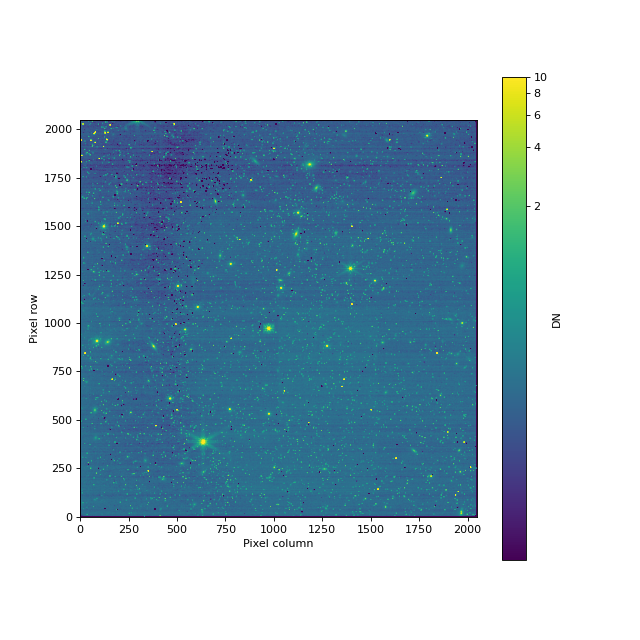

In [26]:
show_image(rate_data, 0.5, 10)

Also, since we set the linearity step's `save_results` parameter to True in our calls above, the pipeline saved the output of the linearity step. In this case, the output file will have the same name as the input uncal file, but with the suffix 'linearity' rather than 'uncal'. 

**NOTE:** This differs slightly from the case where we call the linearity step itself and save the results. In that case, as we will see in the [linearity](#linearity) section, the output file will have the suffix 'linearitystep' rather than 'linearty'.

In [ ]:
linear_file = rate_file.replace('rate.fits', 'linearity.fits')

In [ ]:
lin_data = fits.getdata(linear_file)

We will look in more detail at the effects of the linearity correction step in the [linearity](#linearity) section below. For now, let's just look at the final group of the integration.

In [ ]:
# Let's look at the data in the final group of the linearized data:
show_image(lin_data[0, -1, :, :], 100, 10000)

[Top of Notebook](#top)

<a id='detector1_step_by_step'></a>
## Run the individual pipeline steps

In the sections below we run the steps contained within calwebb_detector1 one at a time, in order to more clearly see what each step is doing. Since our example data are from NIRCam, we will skip the MIRI-specific steps.

<a id='groupscale'></a>
### The `Group Scale` step

#### Summary

This step rescales pixel values in the raw JWST science products in cases where multiple [frames](https://jwst-docs.stsci.edu/understanding-exposure-times#UnderstandingExposureTimes-uptherampHowup-the-rampreadoutswork) were averaged on-board to create the [groups](https://jwst-docs.stsci.edu/understanding-exposure-times#UnderstandingExposureTimes-uptherampHowup-the-rampreadoutswork) in the multiaccum ramp, but the number of frames per group is not a power of 2. This occurs primarily in [NIRSpec IRS^2 data that uses the NRSIRS2 readout pattern (see Table 1)](https://jwst-docs.stsci.edu/near-infrared-spectrograph/nirspec-instrumentation/nirspec-detectors/nirspec-detector-readout-modes-and-patterns) data. Data with no frame averaging, or where the number of frames is a power of 2, will not be affected by this step. See Figure 2 in the [NIRCam detector readout](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-instrumentation/nircam-detector-overview/nircam-detector-readout-patterns) page for some examples of readout patterns where multiple frames are averaged to create each group.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/group_scale/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step does not use any reference files.

#### Run the step

In this case, since we have NIRCam data, the step will be skipped. Let's try running it just to show that it is indeed skipped, and the data are not changed at all.

In [93]:
# Using the run() method
group_scale_step = GroupScaleStep()
group_scale_step.output_dir = output_dir
group_scale_step.save_results = True
group_scale = group_scale_step.run(uncal_file)

2021-04-09 17:24:09,587 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2021-04-09 17:24:09,727 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args ('./jw98765001001_01101_00003_nrcb5_uncal.fits',).
2021-04-09 17:24:09,729 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-04-09 17:24:19,197 - stpipe.GroupScaleStep - INFO - NFRAMES=1 is a power of 2; correction not needed
2021-04-09 17:24:19,198 - stpipe.GroupScaleStep - INFO - Step will be skipped
2021-04-09 17:26:09,142 - stpipe.GroupScaleStep - INFO - Saved model in ./jw98765001001_01101_00003_nrcb5_groupscalestep.fits
2021-04-09 17:26:09,143 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep done


In [94]:
# When the output is saved, the group_scale step will
# attach a suffix of 'group_scale' to the input filename.
group_scale_output_file = os.path.join(output_dir, '{}groupscalestep.fits'.format(input_file_base))

2021-04-09 17:26:09,148 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



For the NIRCam data we are using, there is no frame-averaging done to produce the groups, so the group_scale step does not change the data in any way. You can see at the bottom of the pipeline output above that the step is skipped. Let's move on to the next step.

<a id='dq_init'></a>
### The `Data Quality Initialization` step

#### Summary

This step populates the Data Quality (DQ) mask that is associated with the data file. The DQ flags from the `MASK` reference file are copied into the `PIXELDQ` extension of the input file. A table showing the [mapping of bit values](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/references_general.html#data-quality-flags) in the `MASK` file decribes what types of bad pixels can be flagged. Any other bad pixel types will be ignored.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/dq_init/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the `MASK` reference file. 


#### Run the step

In [95]:
# Using the run() method
dq_init_step = DQInitStep()
dq_init_step.output_dir = output_dir
dq_init_step.save_results = True

# Note that the run() method can be called on EITHER:
# the datamodel instance output from the group_scale
# step.
dq_init = dq_init_step.run(group_scale)

# OR:
# the fits file containing the group_scale output
#dq_init = dq_init_step.run(group_scale_output_file)

2021-04-09 17:26:09,157 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2021-04-09 17:26:09,271 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_groupscalestep.fits>,).
2021-04-09 17:26:09,273 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-04-09 17:26:09,847 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nircam_mask_0032.fits
2021-04-09 17:26:12,318 - stpipe.DQInitStep - WARNING - Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
2021-04-09 17:26:12,427 - stpipe.DQInitStep - WARNING - Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be

The step finished without crashing, but as it is said above, there are some warnings worth noting.
Notably, the `NOISY` and `WEIRD` do not correspond to existing `DQ` mnemonics, so they are ignored. This is expected, and means that the `MASK` reference file contains some pixels flagged as `NOISY` and `WEIRD`. Since these bad pixel types are not present in the list of known types of bad pixels, as shown below, these flags are ignored.

In [96]:
dqflags.pixel

2021-04-09 17:29:00,176 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



{'GOOD': 0,
 'DO_NOT_USE': 1,
 'SATURATED': 2,
 'JUMP_DET': 4,
 'DROPOUT': 8,
 'OUTLIER': 16,
 'PERSISTENCE': 32,
 'AD_FLOOR': 64,
 'RESERVED_4': 128,
 'UNRELIABLE_ERROR': 256,
 'NON_SCIENCE': 512,
 'DEAD': 1024,
 'HOT': 2048,
 'WARM': 4096,
 'LOW_QE': 8192,
 'RC': 16384,
 'TELEGRAPH': 32768,
 'NONLINEAR': 65536,
 'BAD_REF_PIXEL': 131072,
 'NO_FLAT_FIELD': 262144,
 'NO_GAIN_VALUE': 524288,
 'NO_LIN_CORR': 1048576,
 'NO_SAT_CHECK': 2097152,
 'UNRELIABLE_BIAS': 4194304,
 'UNRELIABLE_DARK': 8388608,
 'UNRELIABLE_SLOPE': 16777216,
 'UNRELIABLE_FLAT': 33554432,
 'OPEN': 67108864,
 'ADJ_OPEN': 134217728,
 'UNRELIABLE_RESET': 268435456,
 'MSA_FAILED_OPEN': 536870912,
 'OTHER_BAD_PIXEL': 1073741824,
 'REFERENCE_PIXEL': 2147483648}

The pixel values in the `SCI` extension are not changed in this step. Instead, the DQ flags are copied into the `PIXELDQ` extension. The `GROUPDQ` values are not changed in this step. Let's check the `PIXELDQ` values and see what has changed.

We have the datamodel instance of the output available already, but if you wanted to open the output file from the data quality initiailzation step, the output file has the same name as the input file, with the original suffix replaced by "dqinitstep".

In [97]:
dq_init_output_file = os.path.join(output_dir, '{}dqinitstep.fits'.format(input_file_base))

In [98]:
group_scale_pixeldq = group_scale.pixeldq
dq_init_pixeldq = dq_init.pixeldq

In [99]:
difference_pixelDQ = dq_init_pixeldq - group_scale_pixeldq

In [100]:
idx_pixelDQ = np.where(difference_pixelDQ.flatten() == 0.)[0]
num_flagged = difference_pixelDQ.size - len(idx_pixelDQ)
print('Total pixels in PIXELDQ: {}'.format(difference_pixelDQ.size))
print('{} pixels have no flags.'.format(len(idx_pixelDQ)))
print('{} pixels ({:.2f}% of the detector) have flags.'.format(num_flagged, num_flagged / difference_pixelDQ.size))

Total pixels in PIXELDQ: 4194304
4148789 pixels have no flags.
45515 pixels (0.01% of the detector) have flags.


[Top of Notebook](#top)

<a id='saturation'></a>
## The `Saturation Flagging` step

#### Summary

This step checks the signal values in all pixels across all groups, and adds a [`saturated` flag](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/references_general.html#data-quality-flags) to the `GROUPDQ` extension for pixels and groups where the signal is above the saturation limit.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/saturation/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`SATURATION`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/saturation/reference_files.html) reference file. This file contains a map of the saturation threshold in ADU for each pixel on the detector.

#### Run the step

In [101]:
# Using the run() method
saturation_step = SaturationStep()
saturation_step.output_dir = output_dir
saturation_step.save_results = True

saturation = saturation_step.run(dq_init)

2021-04-09 17:29:00,237 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2021-04-09 17:29:00,319 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_dqinitstep.fits>,).
2021-04-09 17:29:00,321 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-04-09 17:29:00,499 - stpipe.SaturationStep - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nircam_saturation_0066.fits
2021-04-09 17:29:04,141 - stpipe.SaturationStep - WARNING - Keyword NO_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
2021-04-09 17:29:04,142 - stpipe.SaturationStep - WARNING - Keyword FEW_SAMPLES 

If there are any saturated values, they should appear in the `GROUPDQ` arrays. Let's examine the `GROUPDQ` data and see if there are any detected:

In [102]:
saturated = np.where(saturation.groupdq & dqflags.pixel['SATURATED'] > 0)

2021-04-09 17:31:02,807 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [103]:
num_sat_flags = len(saturated[0])
print(('Found {} saturated flags. This may include multiple saturated '
       'groups within a given pixel'.format(num_sat_flags)))

Found 350667 saturated flags. This may include multiple saturated groups within a given pixel


Let's find a pixel that saturated part of the way up the ramp.

In [104]:
# Create a 4D boolean map of whether the saturation flag is present or not.
saturated = (saturation.groupdq & dqflags.pixel['SATURATED'] > 0)

In [105]:
# Collapse that down to a 2D map that lists the number of saturated groups 
# for each pixel.
saturated_2d = np.sum(saturated[0, :, :, :], axis=0)

In [106]:
# Get coordinates of pixels that are saturated in some, but not all, groups.
partial_sat = np.where((saturated_2d > 0) & (saturated_2d < saturated.shape[1]))
print("{} pixels are partially saturated.".format(len(partial_sat[0])))

252 pixels are partially saturated.


Now let's choose one of these partially saturated pixels and look at the signal values up the ramp, along with which groups are flagged as saturated.

In [107]:
sat_y, sat_x = partial_sat
sat_index = 123
y = sat_y[sat_index]
x = sat_x[sat_index]
grps = saturated[0, :, y, x]
print('Saturation flags up the ramp (0 is not saturated, 2 is saturated): {}'
      .format(saturation.groupdq[0, :, y, x]))
print('Pixel signal values up the ramp: {}'.format(saturation.data[0, :, y, x]))

Saturation flags up the ramp (0 is not saturated, 2 is saturated): [0 0 0 2 2 2 2 2 2 2]
Pixel signal values up the ramp: [42250. 45497. 45954. 46126. 46236. 46217. 46295. 46316. 46323. 46350.]


Plot these in order to get a clearer look at the data

In [108]:
groups = np.arange(saturation.data.shape[1])
full_ramp = saturation.data[0, :, y, x]
sat_dq = saturation.groupdq[0, :, y, x].astype(bool)
saturated_points = copy.deepcopy(saturation.data[0, :, y, x])
saturated_points[~sat_dq] = np.nan

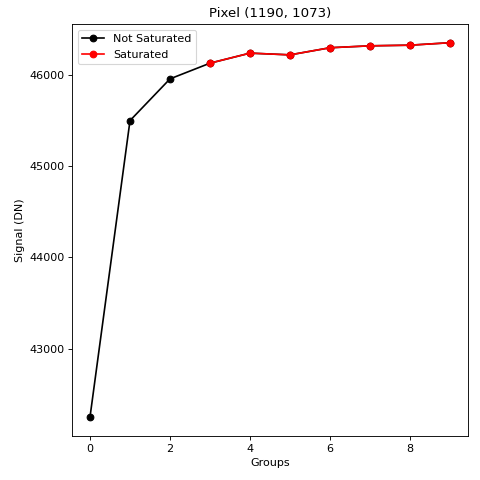

In [109]:
plot_ramps(groups, full_ramp, saturated_points, label1='Not Saturated',
           label2='Saturated', title='Pixel ({}, {})'.format(x, y))

 <a id='superbias'> </a>
## The `Superbias Subtraction` step

#### Summary

This step subtracts the superbias reference frame from each group of the science exposure.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/superbias/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`SUPERBIAS`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/superbias/reference_files.html) reference file. This file contains a map of the superbias signal in ADU for each pixel on the detector.


#### Run the step

In [110]:
# Using the run() method
superbias_step = SuperBiasStep()
superbias_step.output_dir = output_dir
superbias_step.save_results = True

superbias = superbias_step.run(saturation)

2021-04-09 17:31:03,292 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-09 17:31:03,294 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2021-04-09 17:31:03,382 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_saturationstep.fits>,).
2021-04-09 17:31:03,384 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None,

Let's compare how the science products visually look like in comparison with the raw `uncal` data for the last group of the first integration. 

In [111]:
superbias_output_file = os.path.join(output_dir, '{}superbiasstep.fits'.format(input_file_base))

2021-04-09 17:33:43,034 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [112]:
superbias_output_file

'./jw98765001001_01101_00003_nrcb5_superbiasstep.fits'

In [113]:
superbias.data[0, 0, :, :].shape

(2048, 2048)

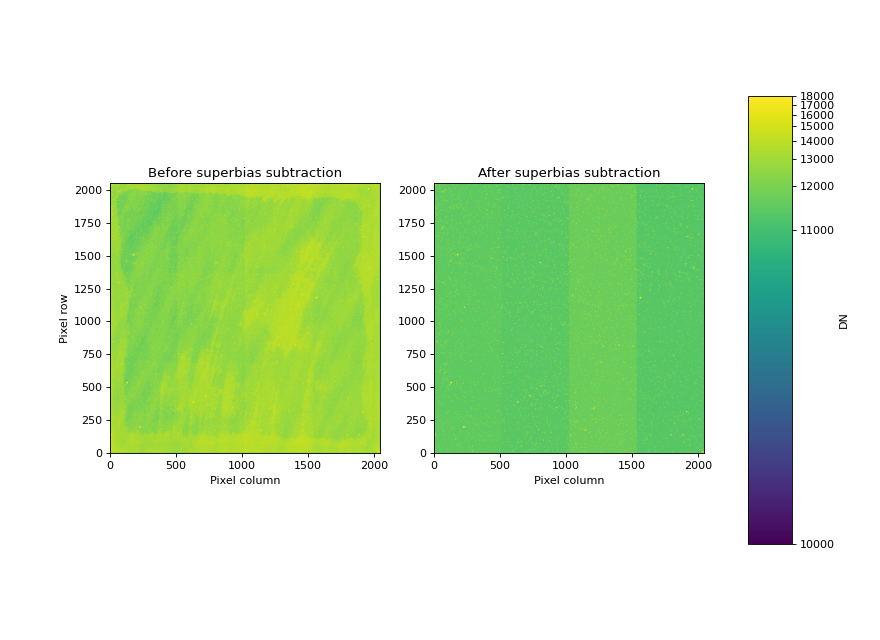

In [114]:
side_by_side(saturation.data[0, 0, :, :], superbias.data[0, 0, :, :], vmin=10000, vmax=18000,
            title1='Before superbias subtraction', title2='After superbias subtraction')

[Top of Notebook](#top)

<a id='refpix'></a>
## The `Reference Pixel Subtraction` step

#### Summary

This step uses the reference pixels, which are not sensitive to illumination, to subtract group- and amplifier-dependent signal originating in the readout electronics from the data. There are two distinct corrections that are applied here.

First, the rows of reference pixels on the top and bottom of the detector are used to subtract amplifier-dependent offsets from each group. Within a given amplifier, the mean value of all reference pixels in even numbered columns is subtracted from the science pixels in the even numbered columns. The same strategy is used for the odd numbered columns. 

The second part of the reference pixel subtraction step uses the reference pixels along the left and right sides of the detector to mitigate 1/f noise. This noise is visible in the data as horizontal banding that stretches across the entire detector. 

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/description.html) of the step.

#### Arguments

[Full details on the optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/refpix/arguments.html).

#### Reference files used

This step does not use any reference files.


#### Run the step

In order to better show the effects from the 2 parts of the reference file subtraction, we're going to run this step twice. First we'll perform only the mean value subtraction using the top and bottom reference pixels. Then on the second run, we'll perform both the mean value subtraction and the 1/f subtraction.

##### Using the run() method

In [115]:
# For this 'partial' run, we need to turn off the 1/f correction that
# uses the reference pixels on the sides of the detector. Also, we'll
# save the output using a unique name so as not to confuse the file
# with the output where we run the entire repix subtraction step.

refpix_step_no_sidepix = RefPixStep()
refpix_step_no_sidepix.output_dir = output_dir
refpix_step_no_sidepix.save_results = True
refpix_step_no_sidepix.output_file = 'refpix_test_no_side_pixels'

# Turn off the 1/f correction
refpix_step_no_sidepix.use_side_ref_pixels = False

# Call using the saturation instance from the previously-run
# saturation step
refpix_no_sidepix = refpix_step_no_sidepix.run(superbias)

2021-04-09 17:33:43,576 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2021-04-09 17:33:43,665 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbiasstep.fits>,).
2021-04-09 17:33:43,684 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/System/Volumes/Data/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/refpix_test_no_side_pixels', 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': False, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-04-09 17:33:43,700 - stpipe.RefPixStep - INFO - use_side_ref_pixels = False
2021-04-09 17:33:43,701 - stpipe.RefPixStep - INFO - odd_even_columns = True
202

Next run the full correction. This will produce the output that we will feed into subsequent steps.

In [116]:
refpix_step = RefPixStep()
refpix_step.output_dir = output_dir
refpix_step.save_results = True

# Call using the saturation instance from the previously-run
# saturation step
refpix = refpix_step.run(superbias)

2021-04-09 17:35:47,097 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-09 17:35:47,100 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2021-04-09 17:35:47,177 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbiasstep.fits>,).
2021-04-09 17:35:47,179 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_fil

##### Using the call() method

The following cells will run the pipeline with the same parameters as the preceeding two cells, but using the `call()` method rather than the `run()` method. In this case we have a separate parameter reference file for each call. 

Let's look at the parameter referece files. The difference between the two is in the `use_side_ref_pixels` entry, on the bottom line of each. These files look fairly similar to that for the Detector1Pipeline. In this case, the step's parameters and values are all listed in the `parameters` entry of the file.

In [117]:
default_refpix_params = asdf.open(refpix_param_reffile)
default_refpix_params.tree

2021-04-09 17:39:31,740 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.7.2'},
 'history': {'entries': [{'description': 'Baseline configuration',
    'time': datetime.datetime(2021, 4, 1, 21, 51, 20)}],
  'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.7.2'}}]},
 'meta': {'author': 'Bryan Hilbert',
  'date': '2021-04-01T17:50:57.310395',
  'description': 'Refpix parameters',
  'exposure': {'type': 'NRC_IMAGE'},
  'instrument': {'name': 'NIRCam'},
  'pedigree': 'GROUND',
  'reftype': 'pars-refpixstep',
  'telescope': 'JWST',
  'title': 'Refpix parameters',
  'useafter': '2000-01-01T00:00:00'},
 'parameters': {'class': 'jwst.refpix.refpix_step.RefPixStep',
  'name': 'refpix',
  'odd_even_columns': True,
  'odd_even_rows': False,
  'side_gain': 1.0,
  'side_smoothing_length': 11,
  'use_side_ref_pixels': True}}

In [118]:
default_refpix_params = asdf.open(refpix_param_reffile_no_side_pix)
default_refpix_params.tree

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.7.2'},
 'history': {'entries': [{'description': 'Baseline configuration',
    'time': datetime.datetime(2021, 4, 1, 21, 51, 20)}],
  'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.7.2'}}]},
 'meta': {'author': 'Bryan Hilbert',
  'date': '2021-04-01T17:50:57.310395',
  'description': 'Refpix parameters',
  'exposure': {'type': 'NRC_IMAGE'},
  'instrument': {'name': 'NIRCam'},
  'pedigree': 'GROUND',
  'reftype': 'pars-refpixstep',
  'telescope': 'JWST',
  'title': 'Refpix parameters',
  'useafter': '2000-01-01T00:00:00'},
 'parameters': {'class': 'jwst.refpix.refpix_step.RefPixStep',
  'name': 'refpix',
  'odd_even_columns': True,
  'odd_even_rows': False,
  'side_gain': 1.0,
  'side_smoothing_length': 11,
  'use_side_ref_pixels': False}}

Now use the `call()` method and the parameter reference file with all of the default settings to run the refernce pixel subtraction step.

In [119]:
refpix_output = RefPixStep.call(superbias, output_dir=output_dir,
                                save_results=True, 
                                config_file=refpix_param_reffile)

2021-04-09 17:39:31,954 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/copy.py:229: ResourceWarning: unclosed file <_io.FileIO name='./refpix_paramfile.asdf' mode='rb' closefd=True>
  for key, value in x.items():

2021-04-09 17:39:32,039 - stpipe.refpix - INFO - RefPixStep instance created.
2021-04-09 17:39:32,115 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbiasstep.fits>,).
2021-04-09 17:39:32,118 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': False}
2021-04-09 17:39:32,133 - stpipe.refpix - INFO - use_s

Call the reference pixel subtraction step again, but use the parameter reference file that has the side reference pixel step turned off.

In [120]:
refpix_output_no_side_pix = RefPixStep.call(superbias, output_dir=output_dir,
                                            output_file='refpix_test_no_side_pixels_via_call',
                                            save_results=True, 
                                            config_file=refpix_param_reffile_no_side_pix)

2021-04-09 17:41:46,540 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-09 17:41:46,728 - stpipe.refpix - INFO - RefPixStep instance created.
2021-04-09 17:41:46,809 - stpipe.refpix - INFO - Step refpix running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_superbiasstep.fits>,).
2021-04-09 17:41:46,812 - stpipe.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/System/Volumes/Data/ifs/jwst/wit/nircam/hilbert/simulated_data_sets/JWebbinars/imaging_mode/refpix_test_no_side_pixels_via_call', 'output_dir': './', 'output_ext': '.fits', 'output_use_model'

#### Examine the output

If you wish to examine the output file from this step, the file is saved with the "refpixstep" suffix.

In [121]:
refpix_output_file = os.path.join(output_dir, '{}refpixstep.fits'.format(input_file_base))

2021-04-09 17:45:38,888 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Let's explore the output from this step. As with all NIR detectors, the outermost 4 rows and columns comprise the reference pixels.

Let's use the datamodels from before and after the reference pixel subtraction to have a look at the data. 

We'll zoom in on the top few rows in order to see the changes. Note how the "odd/even" effect dominates the signal prior to reference pixel subtraction. Even numbered columns and odd numbered columns have significantly different signal levels.

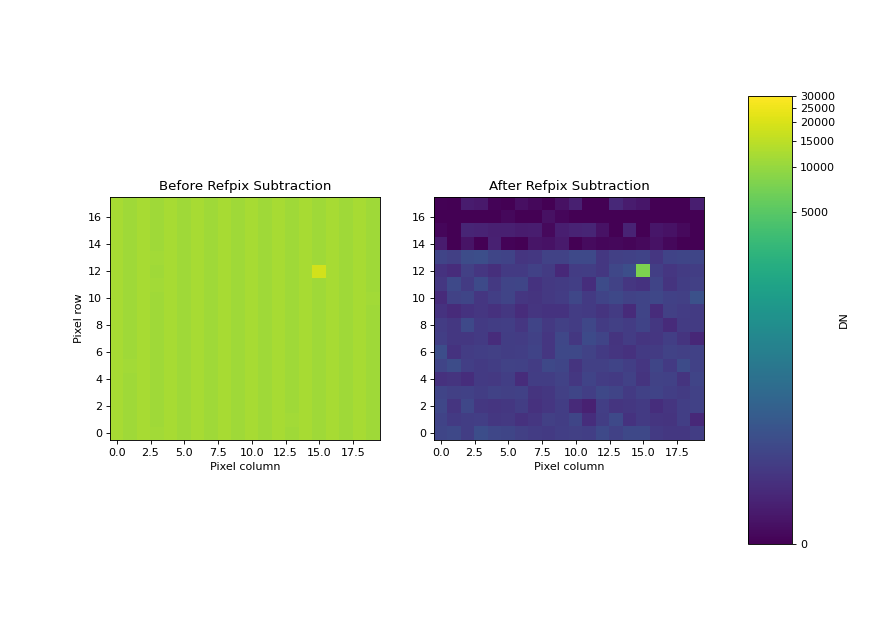

In [122]:
side_by_side(superbias.data[0, 5, 2030:, 1030:1050], refpix.data[0, 5, 2030:, 1030:1050],
             vmin=0, vmax=30000, title1='Before Refpix Subtraction',
             title2='After Refpix Subtraction')

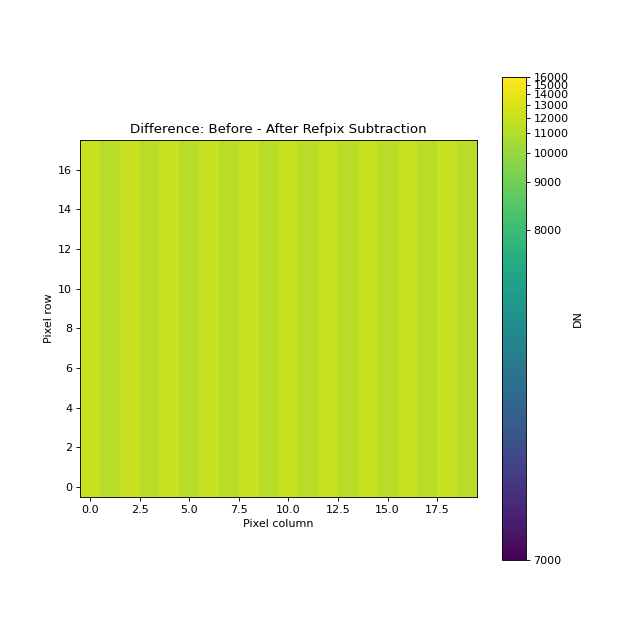

In [123]:
show_image(superbias.data[0, 5, 2030:, 1030:1050] - refpix.data[0, 5, 2030:, 1030:1050],
           vmin=7000, vmax=16000, title='Difference: Before - After Refpix Subtraction')

Now let's look at the difference in the data after the mean value subtraction compared to the case where both the mean value subtraction and the 1/f correction are done.

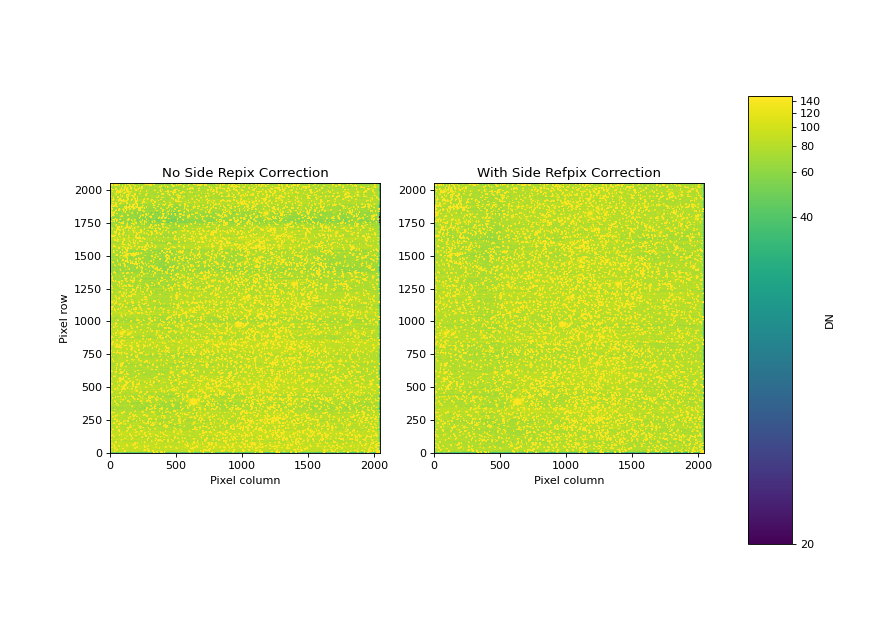

In [124]:
side_by_side(refpix_no_sidepix.data[0, 5, :, :], refpix.data[0, 5, :, :],
             vmin=20, vmax=150, title1='No Side Repix Correction',
             title2='With Side Refpix Correction')

[Top of Notebook](#top)

<a id='linearity'></a>
## The `Linearity Correction` step 

#### Summary

This step applies the classical linearity correction to the data on a pixel-by-pixel, integration-by-integration, group-by-group manner.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/linearity/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`LINEARITY`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/linearity/reference_files.html) reference file. This file contains the polynomial coefficients used to apply the linearity correction to non-linear data.


#### Run the step

In [125]:
# Using the run() method
linearity_step = LinearityStep()
linearity_step.output_dir = output_dir
linearity_step.save_results = True

# Call using the refpix instance from the previously-run
# refpix step
linearity = linearity_step.run(refpix)

2021-04-09 17:45:39,765 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2021-04-09 17:45:39,846 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_refpixstep.fits>,).
2021-04-09 17:45:39,848 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-04-09 17:45:40,024 - stpipe.LinearityStep - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nircam_linearity_0049.fits
2021-04-09 17:45:53,142 - stpipe.LinearityStep - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2021-04-09 17:45:53,143 - stpipe.LinearityStep - WARNING - Keyword UAZ_NO_LIN_SAMP does n

#### Examine the output

The output file from this step has the "linearitystep" suffix.

In [126]:
linearity_output_file = os.path.join(output_dir, '{}linearitystep.fits'.format(input_file_base))

2021-04-09 17:48:25,310 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Let's look at the signal up the ramp for a high signal pixel, in order to more easily see how the linearity correction changed the data. First, identify all pixels with signal values between 40,000 and 60,000 DN in the final group.

In [127]:
well_exposed = np.where((linearity.data[0, -1, :, :] > 40000.) & (linearity.data[0, -1, :, :] < 60000.))

In [128]:
lin_fix = linearity.data[0, 3, :, :] - refpix.data[0, 3, :, :]
well_exposed = np.where((linearity.data[0, -1, :, :] > 40000.) & (lin_fix > 20))

In [129]:
print('{} pixels meet the criteria above.'.format(len(well_exposed[0])))

38 pixels meet the criteria above.


Pick one of these pixels and plot the signal before and after the linearity correction.

In [130]:
index = 3
lin_pix_x, lin_pix_y = (well_exposed[1][index], well_exposed[0][index])

In [131]:
group_nums = np.arange(10)

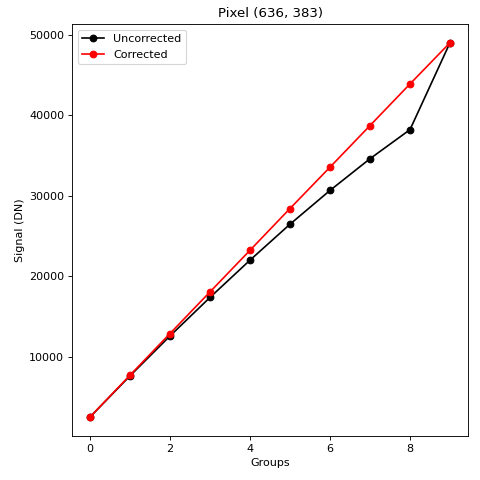

In [132]:
plot_ramps(group_nums, refpix.data[0, :, lin_pix_y, lin_pix_x],
           linearity.data[0, :, lin_pix_y, lin_pix_x], label1='Uncorrected', label2='Corrected',
           title='Pixel ({}, {})'.format(lin_pix_x, lin_pix_y))

In this case, the pixel reached saturation in group 9. So in group 9, the linearity correction made no changes. Between groups 0 to 8, you can see the original signal (in black) becoming more and more non-linear as signal increases, along with how the linearity correction modified the signal (red).

In [133]:
detector1_output_file = '{}rate.fits'.format(input_file_base)
ratedata = fits.getdata(detector1_output_file)

2021-04-09 17:48:25,487 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[Top of Notebook](#top)

<a id='persistence'></a>
## The `Persistence Correction` step 

#### Summary

This step uses a model to calculate the amount of signal in each group of each pixel that comes from persistence. This persistence signal is then subtracted, pixel-by-pixel and group-by-group, from the data.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/description.html) of the step.

#### Arguments

[Optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/arguments.html) for this step include setting the threshold signal value above which pixels are flagged in the DQ extension, as well as saving the subtracted persistence signal in a separate file.

#### Reference files used

This step uses the [`TRAPDENSITY`, `PERSAT`, and `TRAPPARS`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/persistence/reference_files.html) reference files. The TRAPDENSITY file contains a map of the relative number of traps per pixel. The PERSAT reference file contains a map of the persistence saturation level, and the TRAPPARS reference file contains parameters related to the persistence calculation model. 

#### Run the step

In [135]:
# Using the run() method
persist_step = PersistenceStep()
persist_step.output_dir = output_dir
persist_step.save_results = True

# Specify the trapsfilled file, which contains the
# state of the charge traps in the preceding exposure
persist_step.input_trapsfilled = persist_file

# Let's also save a separate file that contains the
# subtracted persistence signal 
persist_step.save_persistence = True

# Call using the refpix instance from the previously-run
# refpix step
persist = persist_step.run(linearity)

2021-04-09 17:48:25,924 - stpipe.PersistenceStep - INFO - PersistenceStep instance created.
2021-04-09 17:48:26,019 - stpipe.PersistenceStep - INFO - Step PersistenceStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_linearitystep.fits>,).
2021-04-09 17:48:26,021 - stpipe.PersistenceStep - INFO - Step PersistenceStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'input_trapsfilled': './jw98765001001_01101_00002_nrcb5_trapsfilled.fits', 'flag_pers_cutoff': 40.0, 'save_persistence': True, 'save_trapsfilled': True}
2021-04-09 17:48:36,281 - stpipe.PersistenceStep - WARNING - Keyword WEIRD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored
2021-04-09 17:49:00,874 - stpipe.PersistenceStep - INFO - Saved model in 

#### Examine the output

The primary output file from this step has the "persistencestep.fits" suffix added.

In [136]:
persist_output_file = os.path.join(output_dir, '{}persistencestep.fits'.format(input_file_base))

2021-04-09 17:53:59,205 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Let's look at the optional output file that contains the subtracted persistence signal. 

In [137]:
persist_signal_file = os.path.join(output_dir, '{}output_pers.fits'.format(input_file_base))

In [138]:
persist_signal = fits.getdata(persist_signal_file)

The file contains the persistence signal for each group of each integration, as we can see by the shape.

In [139]:
persist_signal.shape

(1, 10, 2048, 2048)

In [140]:
np.min(persist_signal), np.max(persist_signal)

(0.0, 0.0)

Let's look at the persistence signal in the final group.

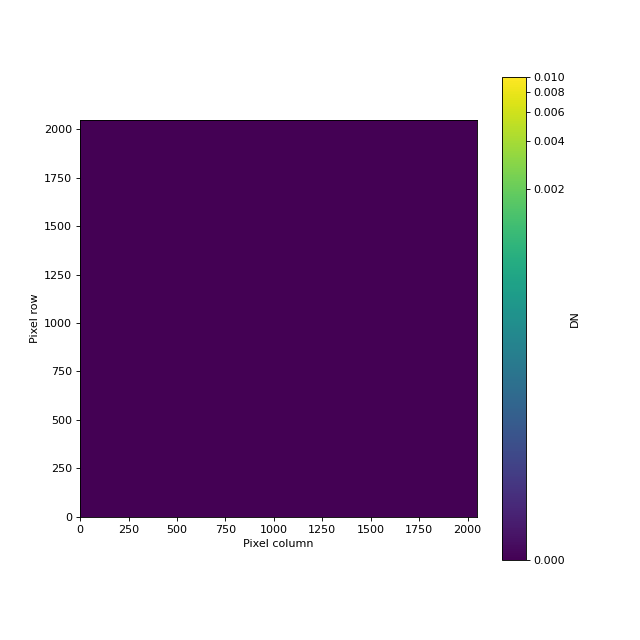

In [141]:
show_image(persist_signal[0, -1, :, :], 0, .01)

<a id='dc'></a>
##  The `Dark Current Subtraction` step 

#### Summary

This step subtracts the dark current, group by group, from the input integrations.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/dark_current/description.html) of the step.

#### Arguments

There are no optional arguments for this step

#### Reference files used

This step uses the [`DARK`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/dark_current/reference_files.html) reference file. This file contains the measured mean dark current associated with the detector and subarray.


#### Run the step

In [142]:
# Using the run() method
dark_step = DarkCurrentStep()
dark_step.output_dir = output_dir
dark_step.save_results = True

# Call using the persistence instance from the previously-run
# persistence step
dark = dark_step.run(persist)

2021-04-09 17:54:15,904 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2021-04-09 17:54:16,070 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_persistencestep.fits>,).
2021-04-09 17:54:16,072 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2021-04-09 17:54:16,237 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_nircam_dark_0048.fits
2021-04-09 18:01:05,248 - stpipe.DarkCurrentStep - WARNING - Keyword HIGH_NOISE does not correspond to an existing DQ mnemonic, so will be ignored
2021-04-09 18:01:05,250 - stpipe.DarkCurrentStep - WARNING - 

In [143]:
dark_output_file = os.path.join(output_dir, '{}darkcurrentstep.fits'.format(input_file_base))

2021-04-09 18:02:55,075 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



[Top of Notebook](#top)

<a id='jump'></a>
## The `Cosmic Ray Flagging` step

#### Summary

This step searches for "jumps" in the ramp data. In this case, a jump in a pixel's ramp is defined as a large deviation in the count rate relative to that in the other groups. When a jump is found, the associated flag is added to the `GROUPDQ` extension for the group and pixel where the jump was detected. The science data are not modified at all. In the subsequent ramp-fitting step, the algorithm will look into the `GROUPDQ` array and ignore any groups where the jump flag has been set.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/description.html) of the step.

#### Arguments

The jump step has [several optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/jump/arguments.html)

#### Reference files used

This step uses the [`READNOISE`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/readnoise_reffile.html) and [`GAIN`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/gain_reffile.html) reference files. These files contain maps of the readnoise and gain values across the detector.


#### Run the step

In [144]:
# Using the run() method
jump_step = JumpStep()
jump_step.output_dir = output_dir
jump_step.save_results = True
jump_step.rejection_threshold = 9

# Call using the dark instance from the previously-run
# dark current subtraction step
jump = jump_step.run(dark)

2021-04-09 18:02:55,094 - stpipe.JumpStep - INFO - JumpStep instance created.
2021-04-09 18:02:55,539 - stpipe.JumpStep - INFO - Step JumpStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_darkcurrentstep.fits>,).
2021-04-09 18:02:55,541 - stpipe.JumpStep - INFO - Step JumpStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 9, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 200.0, 'min_jump_to_flag_neighbors': 10.0}
2021-04-09 18:02:55,550 - stpipe.JumpStep - INFO - CR rejection threshold = 9 sigma
2021-04-09 18:02:55,711 - stpipe.JumpStep - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nircam_gain_0054.fits
2021-04-09 18:02:58,009 - stpipe.JumpStep -

#### Examine the output

In [145]:
jump_output_file = os.path.join(output_dir, '{}jumpstep.fits'.format(input_file_base))

2021-04-09 18:06:11,526 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Let's see what some of these jumps look like:

In [146]:
jump_flags = np.where(jump.groupdq & dqflags.pixel['JUMP_DET'] > 0)
print('{} jump flags detected.'.format(len(jump_flags[0])))

jump_map = (jump.groupdq & dqflags.pixel['JUMP_DET'] > 0)
jump_map_2d = np.sum(jump_map[0, :, :, :], axis=0)
jump_map_indexes = np.where(jump_map_2d > 0)
#jump_map_indexes = np.where(jump.groupdq & dqflags.pixel['JUMP_DET'] > 0)
#hits_per_pix = np.sum(jump_map[0, :, :, :], axis=0)
impacted_pix = np.sum(jump_map_2d > 0)
total_pix = 2048 * 2048
print(('{} pixels ({:.2f}% of the detector) have been flagged with '
      'at least one jump.'.format(impacted_pix, 100. * impacted_pix / total_pix)))

74855 jump flags detected.
45970 pixels (1.10% of the detector) have been flagged with at least one jump.


Plot some of the pixels impacted by jumps. The red marks signify flagged jumps. These signal values will be ignored in subsequent ramp-fitting.

In [147]:
jump_map.shape

(1, 10, 2048, 2048)

In [148]:
group_indexes = np.arange(jump_map.shape[1]).astype(int)

In [149]:
j_index = 10112
jumpy = jump_map_indexes[0][j_index]
jumpx = jump_map_indexes[1][j_index]
jump_grp = jump_map[0, :, jumpy, jumpx]
print('Jump located in group(s) {} of pixel ({}, {})'.format(group_indexes[jump_grp], jumpx, jumpy))

Jump located in group(s) [3] of pixel (983, 438)


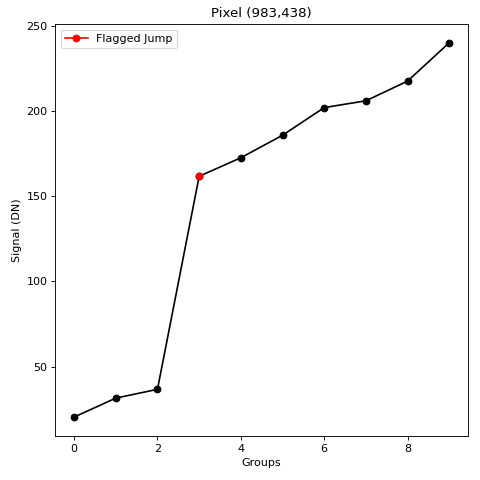

In [150]:
plot_jump(jump.data[0, :, jumpy, jumpx], jump_grp, xpixel=jumpx, ypixel=jumpy)

Plot a grid of some examples of flagged jumps. The red marks signify flagged jumps. These signal values will be ignored in subsequent ramp-fitting.

In [151]:
indexes_to_plot = [200, 401, 600, 30010, 31000, 1202, 1400, 21600, 10112]
jump_data = np.zeros((jump.shape[1], len(indexes_to_plot)))
jump_grps = np.zeros((jump.shape[1], len(indexes_to_plot))).astype(bool)
jump_locs = []
for counter, idx in enumerate(indexes_to_plot):
    #integ, grp, y, x = jump_flags[idx]
    y = jump_map_indexes[0][idx]
    x = jump_map_indexes[1][idx]
    grp = jump_map[0, :, y, x]

    jump_data[:, counter] = jump.data[0, :, y, x]
    jump_grps[:, counter] = grp
    jump_locs.append((x, y))

2021-04-09 18:06:11,877 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



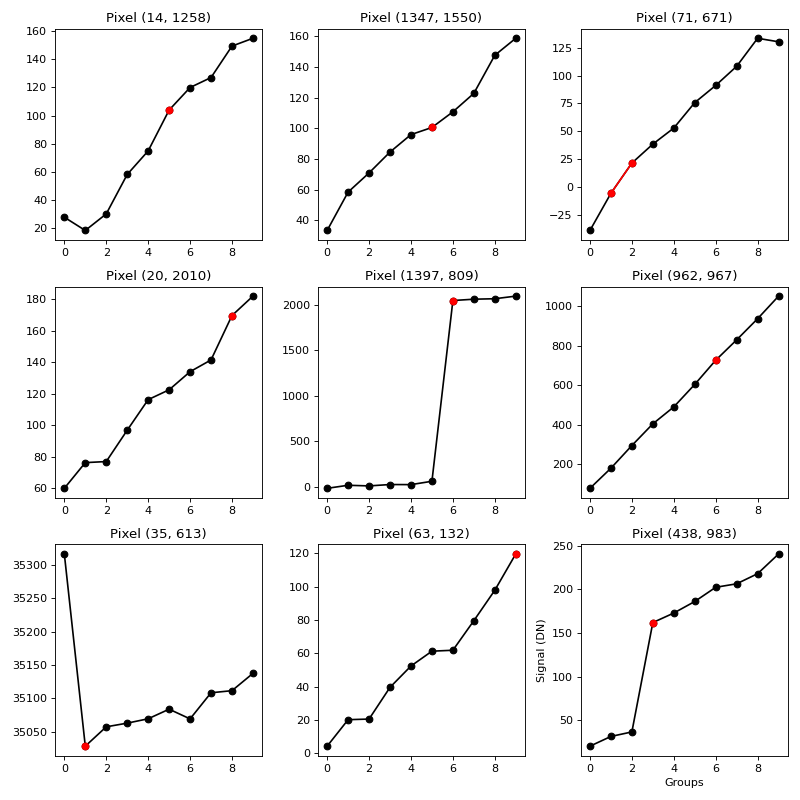

In [152]:
plot_jumps(jump_data, jump_grps, jump_locs)

[Top of Notebook](#top)

<a id='ramp_fitting'></a>
## The `Ramp Fitting` step

#### Summary

This step performs line-fitting to the corrected data, and produces a slope image for each integration. For a given pixel, any groups within an integration that contain a jump flag or that are flagged as saturated are ignored.

For the purposes of this notebook, we will use the `save_opt` parameter to tell the ramp-fitting step to save an optional output file that contains some of the details on the ramp fits. This information will be used for the plots after the step is run. By default, `save_opt` is False and the optional outputs are not saved.


#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/ramp_fitting/description.html) of the step.

#### Arguments

The jump step has [several optional arguments](https://jwst-pipeline.readthedocs.io/en/stable/jwst/ramp_fitting/arguments.html), including the ability to save optional outputs into a second file.

#### Reference files used

This step uses the [`READNOISE`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/readnoise_reffile.html) and [`GAIN`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/gain_reffile.html) reference files. These files contain maps of the readnoise and gain values across the detector.


#### Run the step

In [153]:
# Using the run() method
ramp_fit_step = RampFitStep()
ramp_fit_step.output_dir = output_dir
ramp_fit_step.save_results = True

# Let's save the optional outputs, in order
# to help with visualization later
ramp_fit_step.save_opt = True

# Call using the dark instance from the previously-run
# dark current subtraction step
ramp_fit = ramp_fit_step.run(jump)

2021-04-09 18:06:12,417 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-04-09 18:06:12,420 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2021-04-09 18:06:12,517 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(1, 10, 2048, 2048) from jw98765001001_01101_00003_nrcb5_jumpstep.fits>,).
2021-04-09 18:06:12,520 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_fi

An important detail here is that there are two output files: 

1. The file ending with `*_0_rampfitstep.fits` contains the mean rate image from all the integrations in the exposure.

2. The file ending with `*_1_rampfitstep.fits` contains separate slope images for each integration. In this case our exposure contains only a single integration, so the data in the two files are identical.

In [154]:
rampfit_output_file = os.path.join(output_dir, '{}_0_rampfitstep.fits'.format(input_file_base))

2021-04-09 18:12:55,483 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



We are working with the output datamodels in this notebook. Unlike the preceeding steps, where the output was a single datamodel, the ramp_fitting step outputs a tuple of 2 datamodel instances. The first element in the tuple is the datamodel instance containing the mean rate image, while the second element is the datamodel instance containing a separate slope image for each integration.

In [155]:
type(ramp_fit)

tuple

Show the shape of each element of the tuple. The case with the mean rate image is only 2-dimensional, while the case with one rate image for each integration is 3-dimensional, even in this case where we have only one integration.

In [156]:
ramp_fit[0].shape, ramp_fit[1].shape

((2048, 2048), (1, 2048, 2048))

Here we see that in our case with a single integration, the two datamodel instances contain identical data.

In [157]:
ramp_fit[0].data[500, 500], ramp_fit[1].data[0, 500, 500]

(0.5203967, 0.5203967)

Let's load the data from the third output file, which contains the optional outputs. Our goal is to grab the intercept values from the line-fitting and use them to re-create the plots from the jump step and overplot the best-fit signals on top of the signals that went into the step.

In [158]:
optional_file = os.path.join(output_dir, '{}fitopt.fits'.format(input_file_base))

In [159]:
hdulist = fits.open(optional_file)
hdulist.info()

Filename: ./jw98765001001_01101_00003_nrcb5_fitopt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     163   ()      
  1  SLOPE         1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  2  SIGSLOPE      1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  3  VAR_POISSON    1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  4  VAR_RNOISE    1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  5  YINT          1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  6  SIGYINT       1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  7  PEDESTAL      1 ImageHDU        10   (2048, 2048, 1)   float32   
  8  WEIGHTS       1 ImageHDU        11   (2048, 2048, 4, 1)   float32   
  9  CRMAG         1 ImageHDU        11   (2048, 2048, 8, 1)   float32   
 10  ASDF          1 BinTableHDU     11   1R x 1C   [4879B]   


The intercepts from the line-fitting are stored in the `YINT` extension.

In [160]:
hdulist['YINT'].data[0, :, 200, 200]

array([34.06014,  0.     ,  0.     ,  0.     ], dtype=float32)

For our plots below, we need the intercept values from the line-fitting. Let's ignore all but the first plane of the extension, since those are zeros.

In [161]:
intercepts = hdulist['YINT'].data[0, 0, :, :]
hdulist.close()

For the pixels to be plotted, create linear ramps using the output slopes and intercepts

In [162]:
# Get the exposure time associated with each group
num_groups = ramp_fit[0].meta.exposure.ngroups
group_time = ramp_fit[0].meta.exposure.group_time
group_times = np.arange(num_groups) * group_time

In [163]:
# Reconstruct linear ramps from the slope and intercept values
lin_ramps = np.zeros((jump.shape[1], len(indexes_to_plot)))
for counter, idx in enumerate(indexes_to_plot):
    #integ, grp, y, x = jump_flags[idx]
    y = jump_map_indexes[0][idx]
    x = jump_map_indexes[1][idx]
    grp = jump_map[0, :, y, x]

    rate = ramp_fit[0].data[y, x]
    intercept = intercepts[y, x]
    lin_ramps[:, counter] = intercept + (rate * group_times)    

In [164]:
lin_data = intercepts[jumpy, jumpx] + (ramp_fit[0].data[jumpy, jumpx] * group_times)

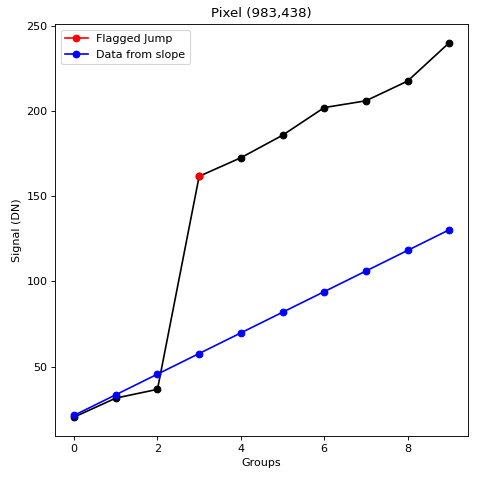

In [165]:
plot_jump(jump.data[0, :, jumpy, jumpx], jump_grp, xpixel=jumpx,
          ypixel=jumpy, slope=lin_data)

2021-04-09 18:12:56,144 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



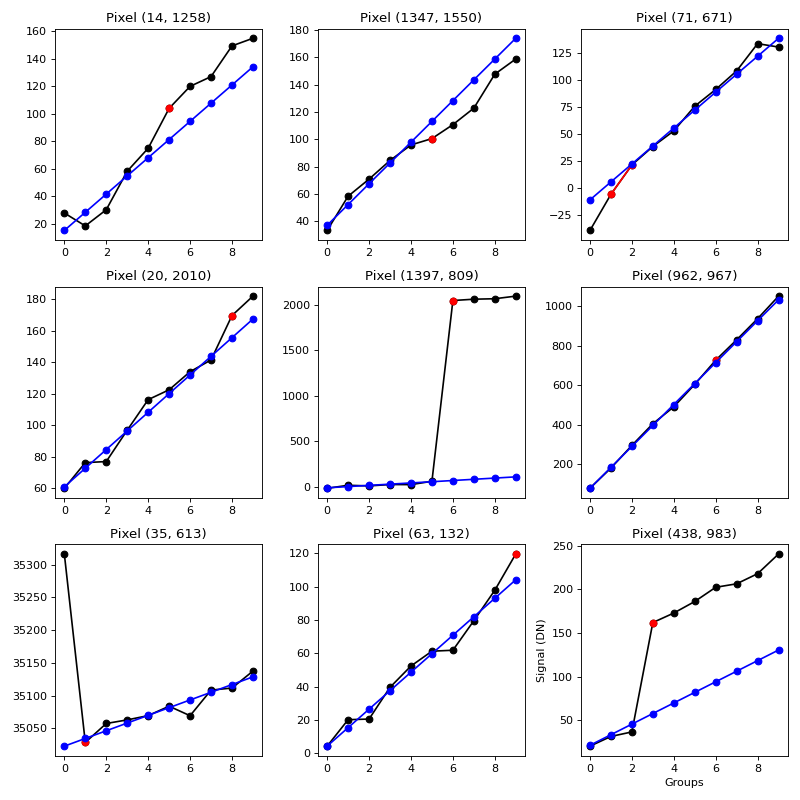

In [166]:
plot_jumps(jump_data, jump_grps, jump_locs, slopes=lin_ramps)

Look at the slope image. 

2021-04-09 18:12:56,656 - stpipe - WARNING - /Users/hilbert/miniconda3/envs/jwst-py3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



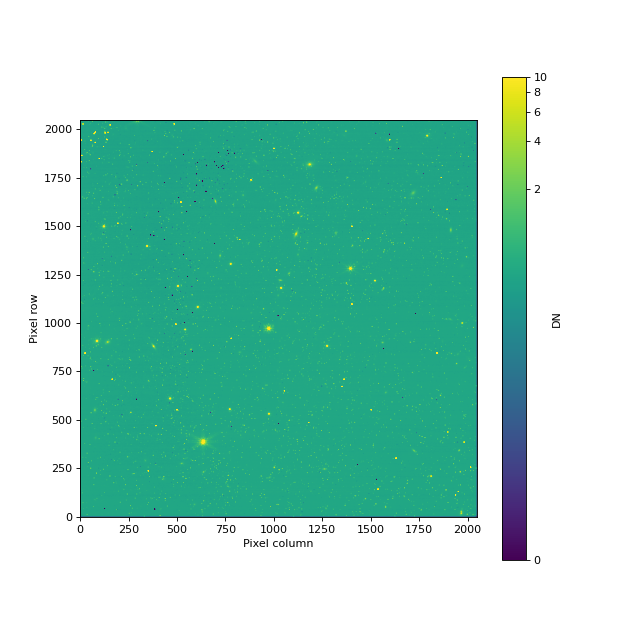

In [167]:
show_image(ramp_fit[0].data, 0, 10)

What's going on with the dark pixels scattered across the left side of the detector? It turns out they have signal values of exactly zero in the slope image. Let's have a closer look, and ignore the reference pixels.

In [168]:
scipix = ramp_fit[0].data[4:2044, 4:2044]
zero_pix = np.where(scipix == 0.0)
print('{} science pixels have a slope that is exactly zero.'.format(len(zero_pix)))

2 science pixels have a slope that is exactly zero.


Pick one of these pixels, and examine the pixel's signals up the ramp, as well as its data quality flags up the ramp.

In [169]:
idx = 45

# Add 4 to the coordinates because we stripped off the 4 columns/rows of 
# refpix in the np.where statement above
y = 4 + low[0][idx]
x = 4 + low[1][idx]
print('({}, {}) has a slope of 0.'.format(x, y))

(174, 58) has a slope of 0.


Print the slope (should be zero), signal values up the ramp, and DQ flags up the ramp

In [170]:
scipix[y, x]

0.60204315

In [171]:
linearity.data[0, :, y, x]

array([ 16.552248,  23.47974 ,  31.785255,  46.962986,  68.373695,
        63.000393,  88.090866,  94.05236 , 111.60792 , 114.2078  ],
      dtype=float32)

In [172]:
linearity.groupdq[0, :, y, x]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

What does a DQ flag value of 2 mean?

In [173]:
dqflags.pixel

{'GOOD': 0,
 'DO_NOT_USE': 1,
 'SATURATED': 2,
 'JUMP_DET': 4,
 'DROPOUT': 8,
 'OUTLIER': 16,
 'PERSISTENCE': 32,
 'AD_FLOOR': 64,
 'RESERVED_4': 128,
 'UNRELIABLE_ERROR': 256,
 'NON_SCIENCE': 512,
 'DEAD': 1024,
 'HOT': 2048,
 'WARM': 4096,
 'LOW_QE': 8192,
 'RC': 16384,
 'TELEGRAPH': 32768,
 'NONLINEAR': 65536,
 'BAD_REF_PIXEL': 131072,
 'NO_FLAT_FIELD': 262144,
 'NO_GAIN_VALUE': 524288,
 'NO_LIN_CORR': 1048576,
 'NO_SAT_CHECK': 2097152,
 'UNRELIABLE_BIAS': 4194304,
 'UNRELIABLE_DARK': 8388608,
 'UNRELIABLE_SLOPE': 16777216,
 'UNRELIABLE_FLAT': 33554432,
 'OPEN': 67108864,
 'ADJ_OPEN': 134217728,
 'UNRELIABLE_RESET': 268435456,
 'MSA_FAILED_OPEN': 536870912,
 'OTHER_BAD_PIXEL': 1073741824,
 'REFERENCE_PIXEL': 2147483648}

So this pixel (and the others with values of 0 in the slope image) have been flagged as saturated in all groups. In this case, the pipeline cannot calculate a slope value, and assigns a value of zero. We'll see in the Stage 3 notebook how these pixels will be ignored when combining multiple exposures to create a final mosaic image.

[Top of Notebook](#top)

## <a id='gain_scale'> The `gain_scale` step </a>

#### Summary

This step applies only to NIRSpec subarray data. It scales rate image values to correct for using a non-standard gain setting.

#### Documentation

[Full description](https://jwst-pipeline.readthedocs.io/en/stable/jwst/gain_scale/description.html) of the step.

#### Arguments

This step has no optional inputs.

#### Reference files used

This step uses the [`GAIN`](https://jwst-pipeline.readthedocs.io/en/stable/jwst/references_general/gain_reffile.html) reference file. 


#### Run the step

In [ ]:
# Using the run() method
gain_scale_step = GainScaleStep()
gain_scale_step.output_dir = output_dir
gain_scale_step.save_results = True

# Call using the dark instance from the previously-run
# dark current subtraction step
gain_scale = gain_scale_step.run(ramp_fit[0])

From the output above, we see that the step was skipped, as expected, since we are using NIRCam data.

<a id='exercises'></a>
## Exercises

### Run MIRI data through the pipeline

Using the supplied MIRI exposure (which can be downloaded in the [Download Data](#download_data) section), run the calwebb_detector1 pipeline, examnine which steps are run, and note the different order compared to the pipeline run above.

### Re-run the `reference pixel subtraction` step

Try re-running the [reference pixel subtraction](#refpix) step and changing the `side_smoothing_length` and/or `side_gain` parameters. Examine the output to see how well the 1/f noise is removed.

That is the end of the Stage 1 pipeline. We have now transformed a single exposure from a raw, multiaccum ramp into a signal rate image after applying detector-level corrections. From here, the data move on to the Stage 2 pipeline. For imaging data such as these, that means the *calwebb_image2* pipeline. This will be shown in the Stage 2 notebook. 

[Top of Notebook](#top)